In [35]:
# -------------------------------
# STEP 1: Import Libraries
# -------------------------------
import pandas as pd
from google.colab import files

# -------------------------------
# STEP 2: Upload Dataset
# -------------------------------
uploaded = files.upload()

# Replace with your actual filename
df = pd.read_csv("Student Depression Dataset.csv")

# -------------------------------
# STEP 3: Handle Missing Values
# -------------------------------
print("Missing values before:", df["Financial Stress"].isnull().sum())

# Impute with median
df["Financial Stress"].fillna(df["Financial Stress"].median(), inplace=True)

# OR use mean instead of median
# df["Financial Stress"].fillna(df["Financial Stress"].mean(), inplace=True)

print("Missing values after:", df["Financial Stress"].isnull().sum())

# -------------------------------
# STEP 4: Save Cleaned File
# -------------------------------
df.to_csv("cleaned_missing_values.csv", index=False)
print("Cleaned file saved as 'cleaned_missing_values.csv'")

Saving Student Depression Dataset.csv to Student Depression Dataset (2).csv
Missing values before: 3
Missing values after: 0


/tmp/ipython-input-1306669458.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Financial Stress"].fillna(df["Financial Stress"].median(), inplace=True)


Cleaned file saved as 'cleaned_missing_values.csv'


Dataset shape: (27901, 18)

Column types:
 id                                         int64
Gender                                    object
Age                                      float64
City                                      object
Profession                                object
Academic Pressure                        float64
Work Pressure                            float64
CGPA                                     float64
Study Satisfaction                       float64
Job Satisfaction                         float64
Sleep Duration                            object
Dietary Habits                            object
Degree                                    object
Have you ever had suicidal thoughts ?     object
Work/Study Hours                         float64
Financial Stress                         float64
Family History of Mental Illness          object
Depression                                 int64
dtype: object

Missing values:
 id                                       0


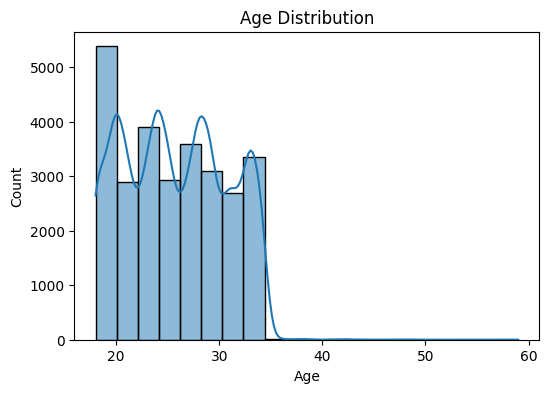

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Basic Info
print("Dataset shape:", df.shape)
print("\nColumn types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())

# 2. Distribution of Age
plt.figure(figsize=(6,4))
sns.histplot(df["Age"], bins=20, kde=True)
plt.title("Age Distribution")
plt.show()

In [37]:
# -------------------------------
# STEP 4: Drop Irrelevant Columns
# -------------------------------

# Check if 'id' exists in columns before dropping
if "id" in df.columns:
    df.drop(columns=["id"], inplace=True)

# Verify
print("Remaining columns after dropping irrelevant ones:\n", df.columns.tolist())

Remaining columns after dropping irrelevant ones:
 ['Gender', 'Age', 'City', 'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Work/Study Hours', 'Financial Stress', 'Family History of Mental Illness', 'Depression']


Dataset shape: (27901, 17)

Column types:
 Gender                                    object
Age                                      float64
City                                      object
Profession                                object
Academic Pressure                        float64
Work Pressure                            float64
CGPA                                     float64
Study Satisfaction                       float64
Job Satisfaction                         float64
Sleep Duration                            object
Dietary Habits                            object
Degree                                    object
Have you ever had suicidal thoughts ?     object
Work/Study Hours                         float64
Financial Stress                         float64
Family History of Mental Illness          object
Depression                                 int64
dtype: object

Missing values:
 Gender                                   0
Age                                      0
City  

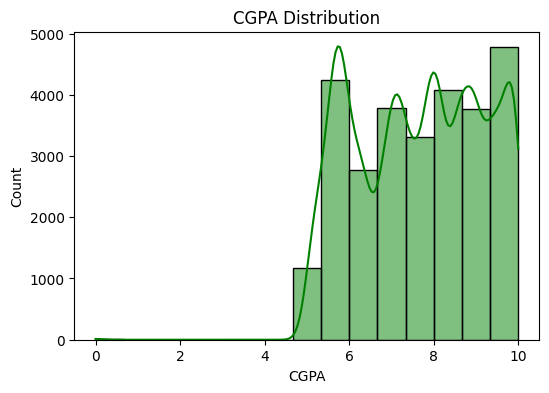

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Basic Info
print("Dataset shape:", df.shape)
print("\nColumn types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())

# 3. CGPA Distribution
plt.figure(figsize=(6,4))
sns.histplot(df["CGPA"], bins=15, kde=True, color="green")
plt.title("CGPA Distribution")
plt.show()

In [39]:
import numpy as np
from sklearn.preprocessing import OrdinalEncoder

# -------------------------------
# Clean & standardize category text
# -------------------------------
def _norm(s):
    if pd.isna(s): return np.nan
    return str(s).strip().lower()

# Standardize Sleep Duration
sleep_map = {
    '<5 hours': '<5 hours',
    'less than 5 hours': '<5 hours',
    '5-6 hours': '5-6 hours',
    '6-7 hours': '6-7 hours',
    '7-8 hours': '7-8 hours',
    '>8 hours': '>8 hours',
    'more than 8 hours': '>8 hours',
    'others': np.nan,   # treat 'Others' as missing; will impute below
    'other': np.nan
}

df['Sleep Duration'] = df['Sleep Duration'].map(_norm).map(sleep_map)

# If any remain unmapped (unexpected spellings), set to NaN
valid_sleep = {'<5 hours','5-6 hours','6-7 hours','7-8 hours','>8 hours'}
df.loc[~df['Sleep Duration'].isin(valid_sleep), 'Sleep Duration'] = np.nan

# Impute missing Sleep Duration with the mode (most frequent)
if df['Sleep Duration'].isna().any():
    mode_sleep = df['Sleep Duration'].mode(dropna=True)
    if not mode_sleep.empty:
        df['Sleep Duration'].fillna(mode_sleep.iloc[0], inplace=True)

# Standardize Dietary Habits
diet_map = {
    'unhealthy': 'Unhealthy',
    'poor': 'Unhealthy',
    'avg': 'Average',
    'average': 'Average',
    'moderate': 'Average',
    'healthy': 'Healthy'
}
df['Dietary Habits'] = df['Dietary Habits'].map(_norm).map(diet_map)

# If any remain unmapped, set to NaN then impute with mode
valid_diet = {'Unhealthy','Average','Healthy'}
df.loc[~df['Dietary Habits'].isin(valid_diet), 'Dietary Habits'] = np.nan
if df['Dietary Habits'].isna().any():
    mode_diet = df['Dietary Habits'].mode(dropna=True)
    if not mode_diet.empty:
        df['Dietary Habits'].fillna(mode_diet.iloc[0], inplace=True)

# -------------------------------
# Ordinal encoding (robust to leftovers)
# -------------------------------
sleep_order = ["<5 hours", "5-6 hours", "6-7 hours", "7-8 hours", ">8 hours"]
diet_order  = ["Unhealthy", "Average", "Healthy"]

# Use handle_unknown to guard against any rare leftover text
ord_enc = OrdinalEncoder(
    categories=[sleep_order, diet_order],
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

df[["Sleep Duration", "Dietary Habits"]] = ord_enc.fit_transform(
    df[["Sleep Duration", "Dietary Habits"]]
)

print("Encoded categories OK. Unique values now are:")
print("Sleep Duration:", sorted(df["Sleep Duration"].unique()))
print("Dietary Habits:", sorted(df["Dietary Habits"].unique()))

Encoded categories OK. Unique values now are:
Sleep Duration: [np.float64(0.0), np.float64(1.0), np.float64(3.0), np.float64(4.0)]
Dietary Habits: [np.float64(0.0), np.float64(1.0), np.float64(2.0)]


/tmp/ipython-input-1344687574.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Sleep Duration'].fillna(mode_sleep.iloc[0], inplace=True)
/tmp/ipython-input-1344687574.py:53: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace

Dataset shape: (27901, 17)

Column types:
 Gender                                    object
Age                                      float64
City                                      object
Profession                                object
Academic Pressure                        float64
Work Pressure                            float64
CGPA                                     float64
Study Satisfaction                       float64
Job Satisfaction                         float64
Sleep Duration                           float64
Dietary Habits                           float64
Degree                                    object
Have you ever had suicidal thoughts ?     object
Work/Study Hours                         float64
Financial Stress                         float64
Family History of Mental Illness          object
Depression                                 int64
dtype: object

Missing values:
 Gender                                   0
Age                                      0
City  

/tmp/ipython-input-1887731977.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Depression", data=df, palette="Set2")


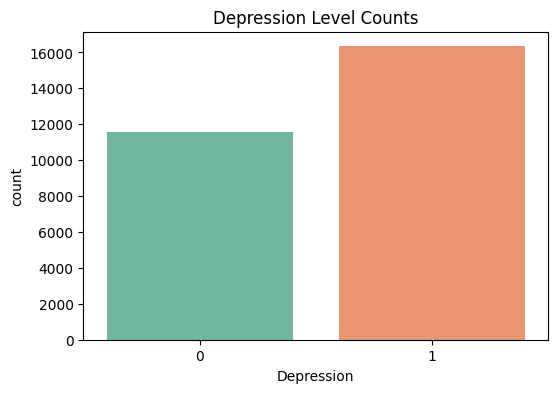

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Basic Info
print("Dataset shape:", df.shape)
print("\nColumn types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())

if "Depression" in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x="Depression", data=df, palette="Set2")
    plt.title("Depression Level Counts")
    plt.show()

In [41]:
import numpy as np
import pandas as pd

before_n = len(df)

# 1) Sanity ranges for common survey scales (adjust if your dataset differs)
scale_0_10_cols = ["Academic Pressure","Work Pressure","Financial Stress","CGPA"]
for col in scale_0_10_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
        df = df[df[col].between(0, 10)]

# 2) No negatives and reasonable caps
non_negative_cols = ["Age","Work/Study Hours"]
for col in non_negative_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
        df = df[df[col] >= 0]

# 3) IQR filter for Work/Study Hours (robust outlier removal)
col = "Work/Study Hours"
if col in df.columns:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = max(0, q1 - 1.5*iqr)   # don’t allow negative hours
    upper = min(24, q3 + 1.5*iqr)  # keep logical cap
    df = df[df[col].between(lower, upper)]

# 4) (Optional) IQR filter for Age (still respecting 10–60)
col = "Age"
if col in df.columns:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = max(10, q1 - 1.5*iqr)
    upper = min(60, q3 + 1.5*iqr)
    df = df[df[col].between(lower, upper)]

df = df.reset_index(drop=True)

after_n = len(df)
print(f"Extra filtering removed {before_n - after_n} rows. Remaining: {after_n}")

Extra filtering removed 12 rows. Remaining: 27889


Dataset shape: (27889, 17)

Column types:
 Gender                                    object
Age                                      float64
City                                      object
Profession                                object
Academic Pressure                        float64
Work Pressure                            float64
CGPA                                     float64
Study Satisfaction                       float64
Job Satisfaction                         float64
Sleep Duration                           float64
Dietary Habits                           float64
Degree                                    object
Have you ever had suicidal thoughts ?     object
Work/Study Hours                         float64
Financial Stress                         float64
Family History of Mental Illness          object
Depression                                 int64
dtype: object

Missing values:
 Gender                                   0
Age                                      0
City  

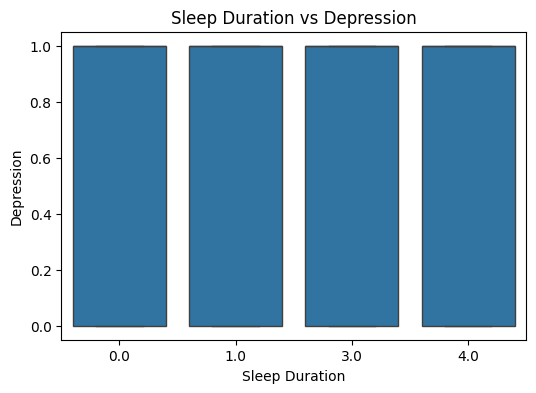

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Basic Info
print("Dataset shape:", df.shape)
print("\nColumn types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())

if "Depression" in df.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="Sleep Duration", y="Depression", data=df)
    plt.title("Sleep Duration vs Depression")
    plt.show()

In [43]:
# -------------------------------
# STEP: Normalization / Scaling
# Scale numeric features:
#   Age, CGPA, Work/Study Hours, Academic Pressure, Work Pressure, Financial Stress
# -------------------------------
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler  # (Z-score)
# from sklearn.preprocessing import MinMaxScaler  # (0–1) <-- optional alternative
import joblib

# Define the intended numeric columns
numeric_features = [
    "Age",
    "CGPA",
    "Work/Study Hours",
    "Academic Pressure",
    "Work Pressure",
    "Financial Stress",
]

# Keep only columns that actually exist (prevents KeyErrors)
numeric_cols_present = [c for c in numeric_features if c in df.columns]
if not numeric_cols_present:
    raise ValueError("None of the expected numeric columns are present to scale.")

# Coerce to numeric (if any are object dtype)
for c in numeric_cols_present:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Option A: Overwrite in place (common for modeling)
scaler = StandardScaler()
df[numeric_cols_present] = scaler.fit_transform(df[numeric_cols_present])

# (Optional) Persist the scaler for later use (e.g., on test or production data)
joblib.dump(scaler, "scaler_standard.pkl")
print("Scaled columns:", numeric_cols_present)
print("Scaler saved to scaler_standard.pkl")
print("df shape after scaling:", df.shape)

# --------- OPTIONAL: Alternative that adds _scaled columns (keeps originals) ----------
# mm = MinMaxScaler()
# df[[c + "_scaled" for c in numeric_cols_present]] = mm.fit_transform(df[numeric_cols_present])
# joblib.dump(mm, "scaler_minmax.pkl")
# print("Also created MinMax-scaled copies with suffix _scaled.")

Scaled columns: ['Age', 'CGPA', 'Work/Study Hours', 'Academic Pressure', 'Work Pressure', 'Financial Stress']
Scaler saved to scaler_standard.pkl
df shape after scaling: (27889, 17)


Dataset shape: (27889, 17)

Column types:
 Gender                                    object
Age                                      float64
City                                      object
Profession                                object
Academic Pressure                        float64
Work Pressure                            float64
CGPA                                     float64
Study Satisfaction                       float64
Job Satisfaction                         float64
Sleep Duration                           float64
Dietary Habits                           float64
Degree                                    object
Have you ever had suicidal thoughts ?     object
Work/Study Hours                         float64
Financial Stress                         float64
Family History of Mental Illness          object
Depression                                 int64
dtype: object

Missing values:
 Gender                                   0
Age                                      0
City  

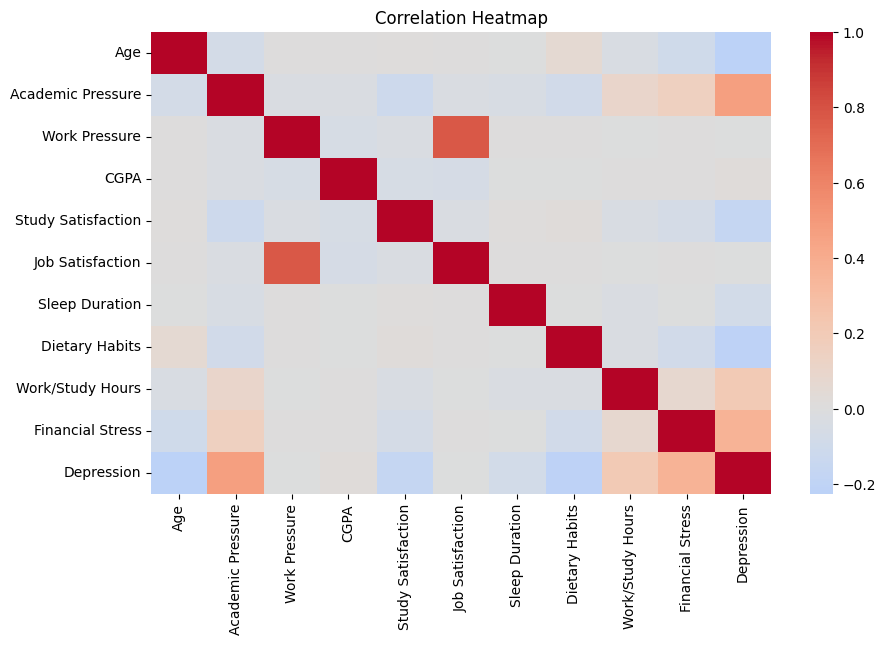

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Basic Info
print("Dataset shape:", df.shape)
print("\nColumn types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())


# 6. Correlation Heatmap
plt.figure(figsize=(10,6))
# Select only numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=np.number)
sns.heatmap(numeric_df.corr(), cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Heatmap")
plt.show()

In [45]:
# -------------------------------
# STEP: PCA (Dimensionality Reduction)
# -------------------------------
from sklearn.decomposition import PCA

# Keep only numeric columns for PCA
numeric_df = df.select_dtypes(include=[np.number])

pca = PCA(n_components=0.95)  # keep 95% variance
pca_data = pca.fit_transform(numeric_df)

print("Original shape:", numeric_df.shape)
print("Reduced shape (PCA):", pca_data.shape)

# Convert PCA result back to DataFrame
df_pca = pd.DataFrame(pca_data, columns=[f"PC{i+1}" for i in range(pca_data.shape[1])])

# Save PCA-transformed dataset
df_pca["Depression"] = df["Depression"].values  # keep target
df_pca.to_csv("step6_pca_features.csv", index=False)


Original shape: (27889, 11)
Reduced shape (PCA): (27889, 9)


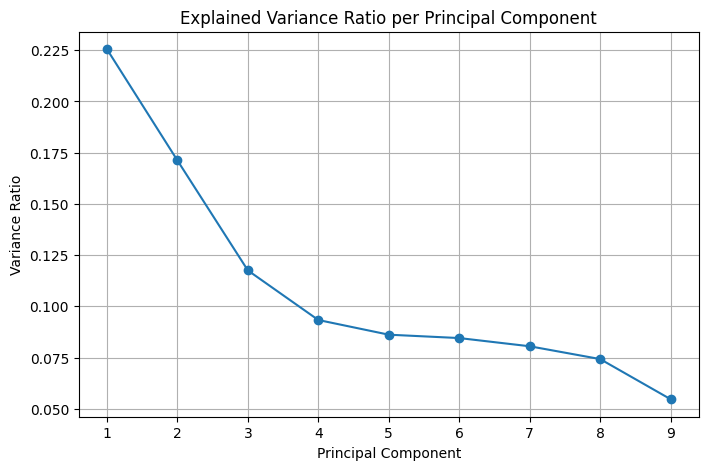

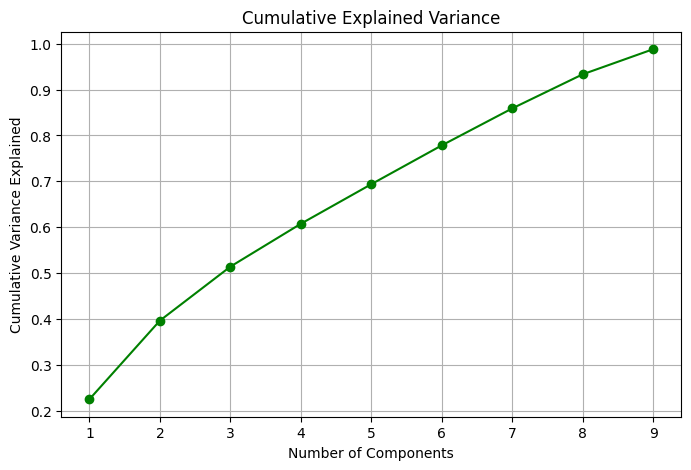

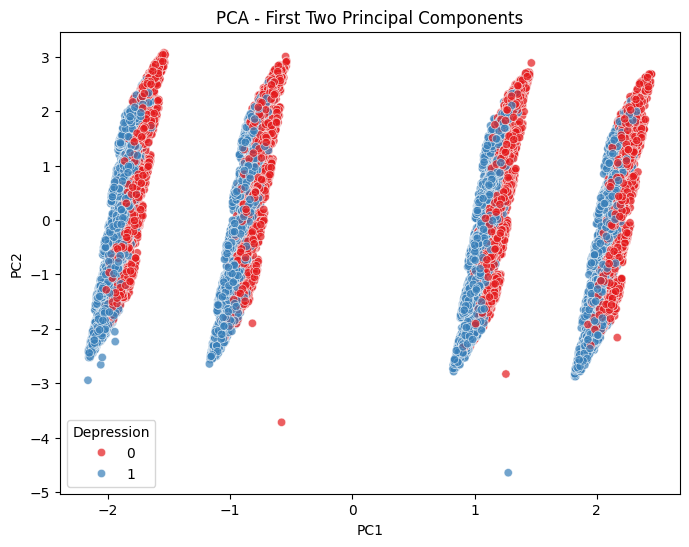

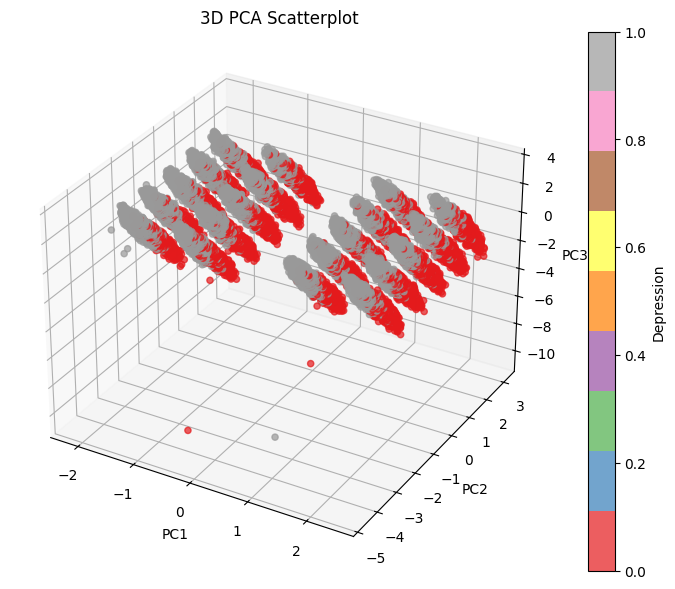

In [53]:
# -------------------------------
# STEP: PCA Visualization
# -------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Explained variance ratio (how much info each PC holds)
plt.figure(figsize=(8,5))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1),
         pca.explained_variance_ratio_, marker='o')
plt.title("Explained Variance Ratio per Principal Component")
plt.xlabel("Principal Component")
plt.ylabel("Variance Ratio")
plt.grid(True)
plt.show()

# 2. Cumulative variance explained
plt.figure(figsize=(8,5))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1),
         pca.explained_variance_ratio_.cumsum(), marker='o', color="green")
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Explained")
plt.grid(True)
plt.show()

# 3. Scatterplot of first 2 PCs, colored by Depression
if "Depression" in df_pca.columns:
    plt.figure(figsize=(8,6))
    sns.scatterplot(
        x="PC1", y="PC2",
        hue="Depression",
        palette="Set1",
        data=df_pca,
        alpha=0.7
    )
    plt.title("PCA - First Two Principal Components")
    plt.legend(title="Depression")
    plt.show()

# 4. 3D scatterplot (optional) if more separation is needed
from mpl_toolkits.mplot3d import Axes3D

if df_pca.shape[1] > 3:  # check if we have at least PC3
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111, projection="3d")
    scatter = ax.scatter(
        df_pca["PC1"], df_pca["PC2"], df_pca["PC3"],
        c=df_pca["Depression"], cmap="Set1", alpha=0.7
    )
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    plt.title("3D PCA Scatterplot")
    plt.colorbar(scatter, label="Depression")
    plt.show()


In [46]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Features and target
X = df_pca.drop(columns=["Depression"], errors="ignore")
y = df_pca["Depression"]

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
print("\n--- Regression Evaluation ---")
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))


--- Regression Evaluation ---
Mean Squared Error: 0.1253992265989593
R² Score: 0.4828943536878584


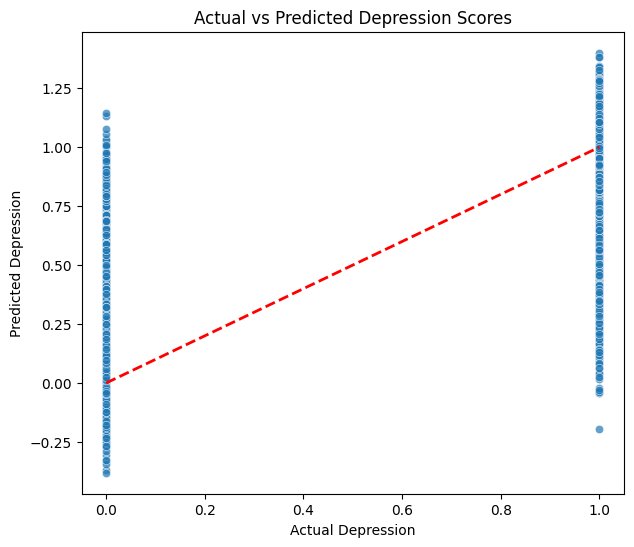

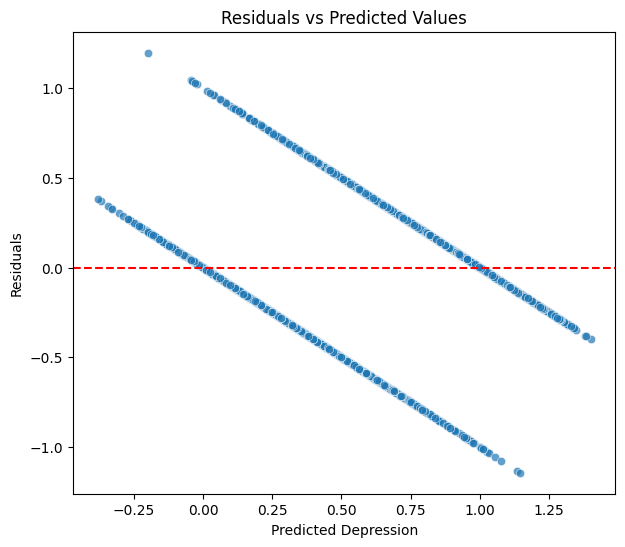

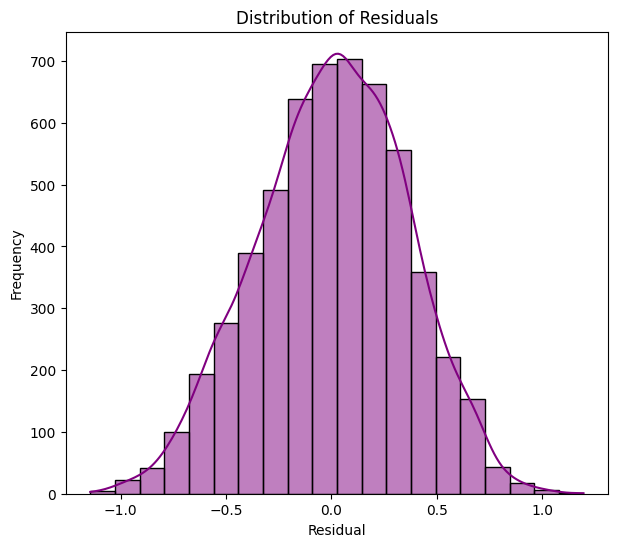

In [54]:
# -------------------------------
# STEP: Regression Visualization
# -------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Scatter plot: Actual vs Predicted
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2)  # ideal line
plt.title("Actual vs Predicted Depression Scores")
plt.xlabel("Actual Depression")
plt.ylabel("Predicted Depression")
plt.show()

# 2. Residuals plot
residuals = y_test - y_pred
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Depression")
plt.ylabel("Residuals")
plt.show()

# 3. Distribution of residuals
plt.figure(figsize=(7,6))
sns.histplot(residuals, kde=True, color="purple", bins=20)
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()


In [48]:
# -------------------------------
# STEP: Binning / Discretization
# -------------------------------
import pandas as pd

before_cols = df.shape[1]

# 1. Age → grouped bins
df["AgeGroup"] = pd.cut(
    df["Age"],
    bins=[15, 20, 25, 30, 40, 60],
    labels=["15-20", "21-25", "26-30", "31-40", "41-60"]
)

# 2. CGPA → grouped bins
df["CGPA_Level"] = pd.cut(
    df["CGPA"],
    bins=[0, 5, 7, 10],
    labels=["Low", "Medium", "High"]
)

# 3. Convert to dummy/one-hot encoding
df = pd.get_dummies(df, columns=["AgeGroup", "CGPA_Level"], drop_first=True)

after_cols = df.shape[1]

print(f"Binning complete. Columns before: {before_cols}, after: {after_cols}")
print("New columns added:", [c for c in df.columns if "AgeGroup" in c or "CGPA_Level" in c])
print(df.head())

Binning complete. Columns before: 17, after: 23
New columns added: ['AgeGroup_21-25', 'AgeGroup_26-30', 'AgeGroup_31-40', 'AgeGroup_41-60', 'CGPA_Level_Medium', 'CGPA_Level_High']
   Gender       Age           City Profession  Academic Pressure  \
0    Male  1.473423  Visakhapatnam    Student           1.345356   
1  Female -0.371340      Bangalore    Student          -0.826312   
2    Male  1.063476       Srinagar    Student          -0.102423   
3  Female  0.448555       Varanasi    Student          -0.102423   
4  Female -0.166366         Jaipur    Student           0.621467   

   Work Pressure      CGPA  Study Satisfaction  Job Satisfaction  \
0      -0.009779  0.893297                 2.0               0.0   
1      -0.009779 -1.194027                 5.0               0.0   
2      -0.009779 -0.425729                 5.0               0.0   
3      -0.009779 -1.404799                 2.0               0.0   
4      -0.009779  0.322172                 3.0               0.0   

  

AgeGroup column not found. Skipping Age Group distribution plot.
CGPA_Level column not found. Skipping CGPA Level distribution plot.


/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


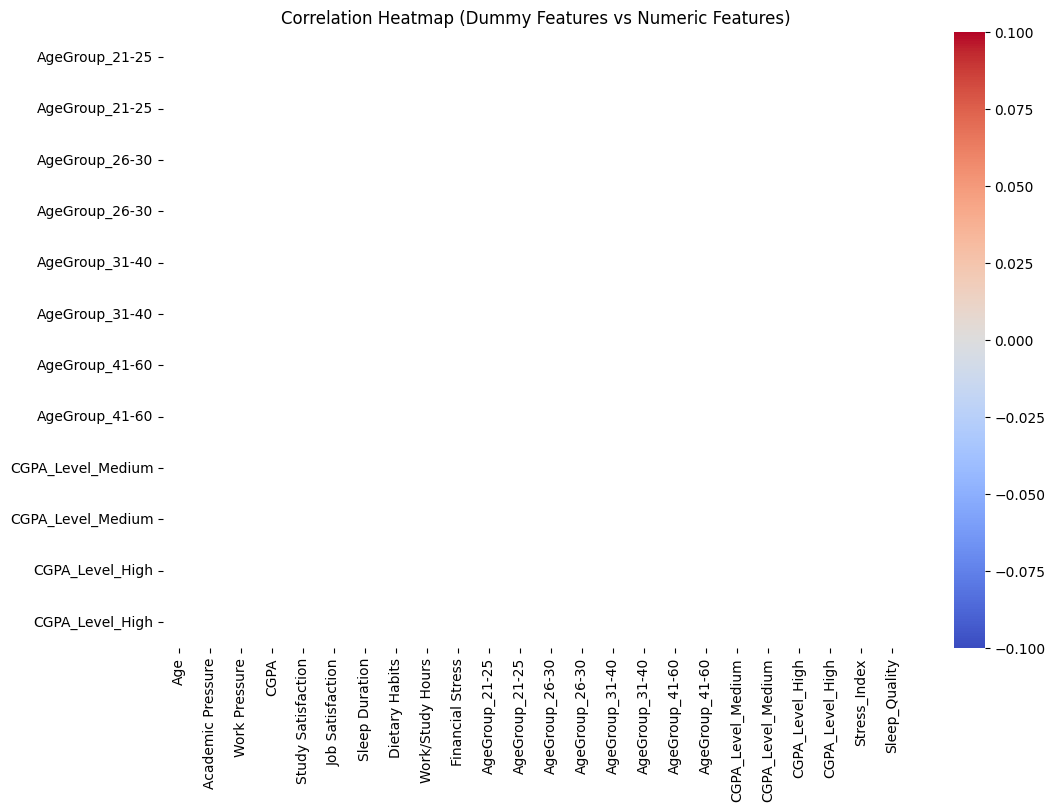

AgeGroup column not found. Skipping Depression vs Age Group boxplot.
CGPA_Level column not found. Skipping Depression vs CGPA Level boxplot.


In [56]:
# -------------------------------
# STEP: Visualization after Binning / Discretization
# -------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Count plot for AgeGroup (original categorical view)
# Use the existing 'AgeGroup' column for plotting
if "AgeGroup" in df.columns:
    plt.figure(figsize=(8,5))
    # Reorder categories for plotting if necessary
    age_order = ["15-20", "21-25", "26-30", "31-40", "41-60"]
    sns.countplot(x="AgeGroup", data=df, order=age_order)
    plt.title("Age Group Distribution")
    plt.xlabel("Age Group")
    plt.ylabel("Count")
    plt.show()
else:
    print("AgeGroup column not found. Skipping Age Group distribution plot.")


# 2. Count plot for CGPA_Level
# Use the existing 'CGPA_Level' column for plotting
if "CGPA_Level" in df.columns:
    plt.figure(figsize=(8,5))
    # Reorder categories for plotting if necessary
    cgpa_order = ["Low", "Medium", "High"]
    sns.countplot(x="CGPA_Level", data=df, order=cgpa_order)
    plt.title("CGPA Level Distribution")
    plt.xlabel("CGPA Level")
    plt.ylabel("Count")
    plt.show()
else:
     print("CGPA_Level column not found. Skipping CGPA Level distribution plot.")


# 3. Heatmap: correlation of dummy columns with numeric features
# Identify dummy columns based on the pattern created in cell tQkiYPWh10hH
# Assuming dummy columns were created from 'AgeGroup' and 'CGPA_Level'
age_dummy_cols = [c for c in df.columns if c.startswith("AgeGroup_")]
cgpa_dummy_cols = [c for c in df.columns if c.startswith("CGPA_Level_")]
dummy_cols = age_dummy_cols + cgpa_dummy_cols

num_cols = df.select_dtypes(include=['number']).columns.tolist()

# Ensure there are dummy columns and numeric columns before attempting heatmap
if dummy_cols and num_cols:
    # Filter out the target column if it's in num_cols to avoid correlation with itself
    if "Depression" in num_cols:
        num_cols.remove("Depression")

    # Ensure there are still numeric columns after removing target
    if num_cols:
        plt.figure(figsize=(12,8)) # Increased size for better readability
        # Select only the relevant columns for correlation
        corr_data = df[dummy_cols + num_cols]
        # Calculate correlation matrix
        corr_matrix = corr_data.corr()
        # Select only the correlations between dummy columns and numeric columns
        corr_subset = corr_matrix.loc[dummy_cols, num_cols]

        sns.heatmap(corr_subset, annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size": 8})
        plt.title("Correlation Heatmap (Dummy Features vs Numeric Features)")
        plt.show()
    else:
        print("No numeric columns (excluding target) found for heatmap.")
else:
    print("No dummy or numeric columns found for heatmap.")


# 4. Boxplot: Depression vs AgeGroup (if Depression exists)
# Use the existing 'AgeGroup' column for plotting
if "Depression" in df.columns and "AgeGroup" in df.columns:
    plt.figure(figsize=(8,5))
    # Reorder categories for plotting if necessary
    age_order = ["15-20", "21-25", "26-30", "31-40", "41-60"]
    sns.boxplot(x="AgeGroup", y="Depression", data=df, order=age_order)
    plt.title("Depression Score by Age Group")
    plt.xlabel("Age Group")
    plt.ylabel("Depression Score")
    plt.show()
elif "Depression" not in df.columns:
    print("Depression column not found. Skipping Depression vs Age Group boxplot.")
elif "AgeGroup" not in df.columns:
     print("AgeGroup column not found. Skipping Depression vs Age Group boxplot.")


# 5. Boxplot: Depression vs CGPA_Level
# Use the existing 'CGPA_Level' column for plotting
if "Depression" in df.columns and "CGPA_Level" in df.columns:
    plt.figure(figsize=(8,5))
    # Reorder categories for plotting if necessary
    cgpa_order = ["Low", "Medium", "High"]
    sns.boxplot(x="CGPA_Level", y="Depression", data=df, order=cgpa_order)
    plt.title("Depression Score by CGPA Level")
    plt.xlabel("CGPA Level")
    plt.ylabel("Depression Score")
    plt.show()
elif "Depression" not in df.columns:
    print("Depression column not found. Skipping Depression vs CGPA Level boxplot.")
elif "CGPA_Level" not in df.columns:
    print("CGPA_Level column not found. Skipping Depression vs CGPA Level boxplot.")

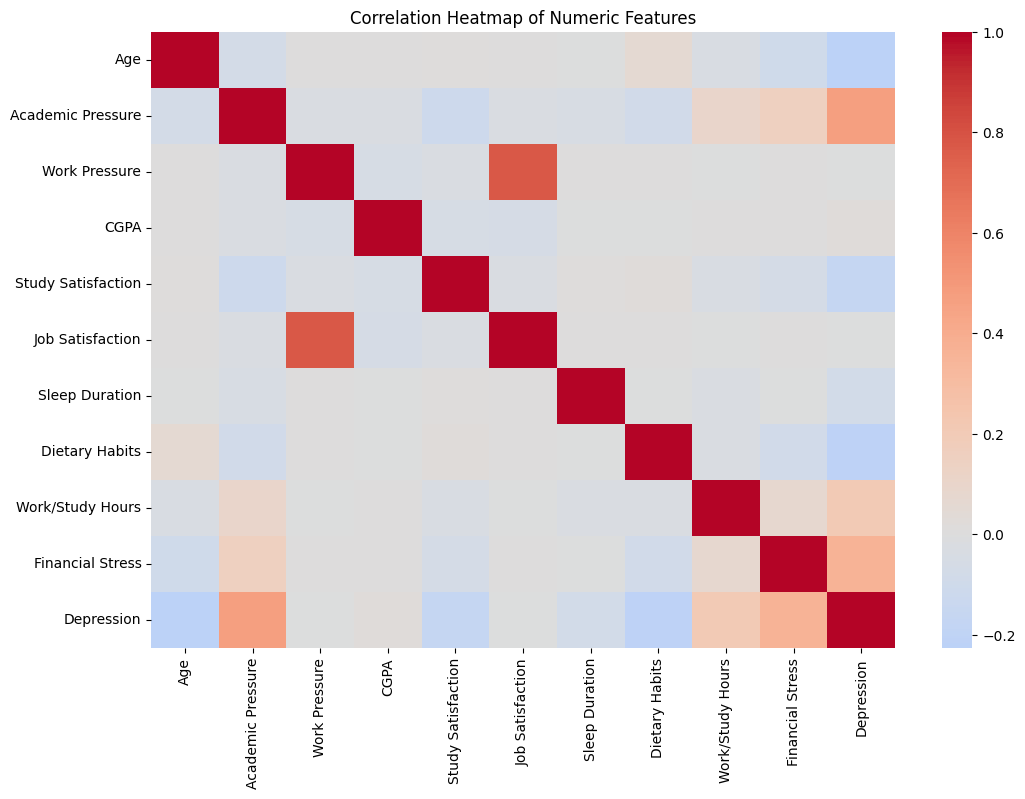


Variance Inflation Factor (VIF):
              Feature       VIF
4  Study Satisfaction  2.556868
5    Job Satisfaction  2.464347
2       Work Pressure  2.463402
6      Sleep Duration  2.004982
7      Dietary Habits  1.966517
1   Academic Pressure  1.038915
9    Financial Stress  1.038709
0                 Age  1.015734
8    Work/Study Hours  1.013826
3                CGPA  1.004583


In [49]:
# -------------------------------
# STEP: Correlation & Multicollinearity Check
# -------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. Correlation Heatmap
plt.figure(figsize=(12,8))
numeric_df = df.select_dtypes(include=[np.number])   # only numeric features
corr = numeric_df.corr()

sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

# 2. Variance Inflation Factor (VIF)
# Drop target column if present
X_vif = numeric_df.drop(columns=["Depression"], errors="ignore")

vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print("\nVariance Inflation Factor (VIF):")
print(vif_data.sort_values(by="VIF", ascending=False))

In [50]:
# -------------------------------
# STEP: Feature Engineering + Save CSV
# -------------------------------
import pandas as pd
import numpy as np
from google.colab import files

added = []

# Ensure required columns are numeric
num_needed = [
    "Academic Pressure", "Work Pressure", "Financial Stress",
    "Sleep Duration", "Work/Study Hours"
]
for col in num_needed:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# 1) Stress Index = Academic + Work + Financial stress
needed_stress = ["Academic Pressure", "Work Pressure", "Financial Stress"]
if all(c in df.columns for c in needed_stress):
    df["Stress_Index"] = df["Academic Pressure"] + df["Work Pressure"] + df["Financial Stress"]
    added.append("Stress_Index")
else:
    missing = [c for c in needed_stress if c not in df.columns]
    print(f"[WARN] Skipped Stress_Index (missing columns: {missing})")

# 2) Sleep Quality = Sleep Duration + Work/Study Hours
needed_sleep = ["Sleep Duration", "Work/Study Hours"]
if all(c in df.columns for c in needed_sleep):
    df["Sleep_Quality"] = df["Sleep Duration"] + df["Work/Study Hours"]
    added.append("Sleep_Quality")
else:
    missing = [c for c in needed_sleep if c not in df.columns]
    print(f"[WARN] Skipped Sleep_Quality (missing columns: {missing})")

print(f"Added engineered features: {added}")
print(df[[c for c in added if c in df.columns]].describe())

# -------------------------------
# SAVE & DOWNLOAD
# -------------------------------
out_path = "student_depression_features.csv"
df.to_csv(out_path, index=False)
print(f"\nSaved to: {out_path}  |  Shape: {df.shape}")

# Convert all boolean columns to 0 and 1
df = df.astype({col: int for col in df.columns if df[col].dtype == 'bool'})

# Double-check conversion
print(df.dtypes.head(20))



Added engineered features: ['Stress_Index', 'Sleep_Quality']
       Stress_Index  Sleep_Quality
count  2.788900e+04   27889.000000
mean  -2.751573e-17       1.877909
std    1.806393e+00       1.856497
min   -3.772507e+00      -1.930685
25%   -9.613769e-01       0.496886
50%   -1.530605e-01       1.766616
75%    1.210291e+00       3.496886
max    1.119493e+02       5.306076

Saved to: student_depression_features.csv  |  Shape: (27889, 25)
Gender                                    object
Age                                      float64
City                                      object
Profession                                object
Academic Pressure                        float64
Work Pressure                            float64
CGPA                                     float64
Study Satisfaction                       float64
Job Satisfaction                         float64
Sleep Duration                           float64
Dietary Habits                           float64
Degree             

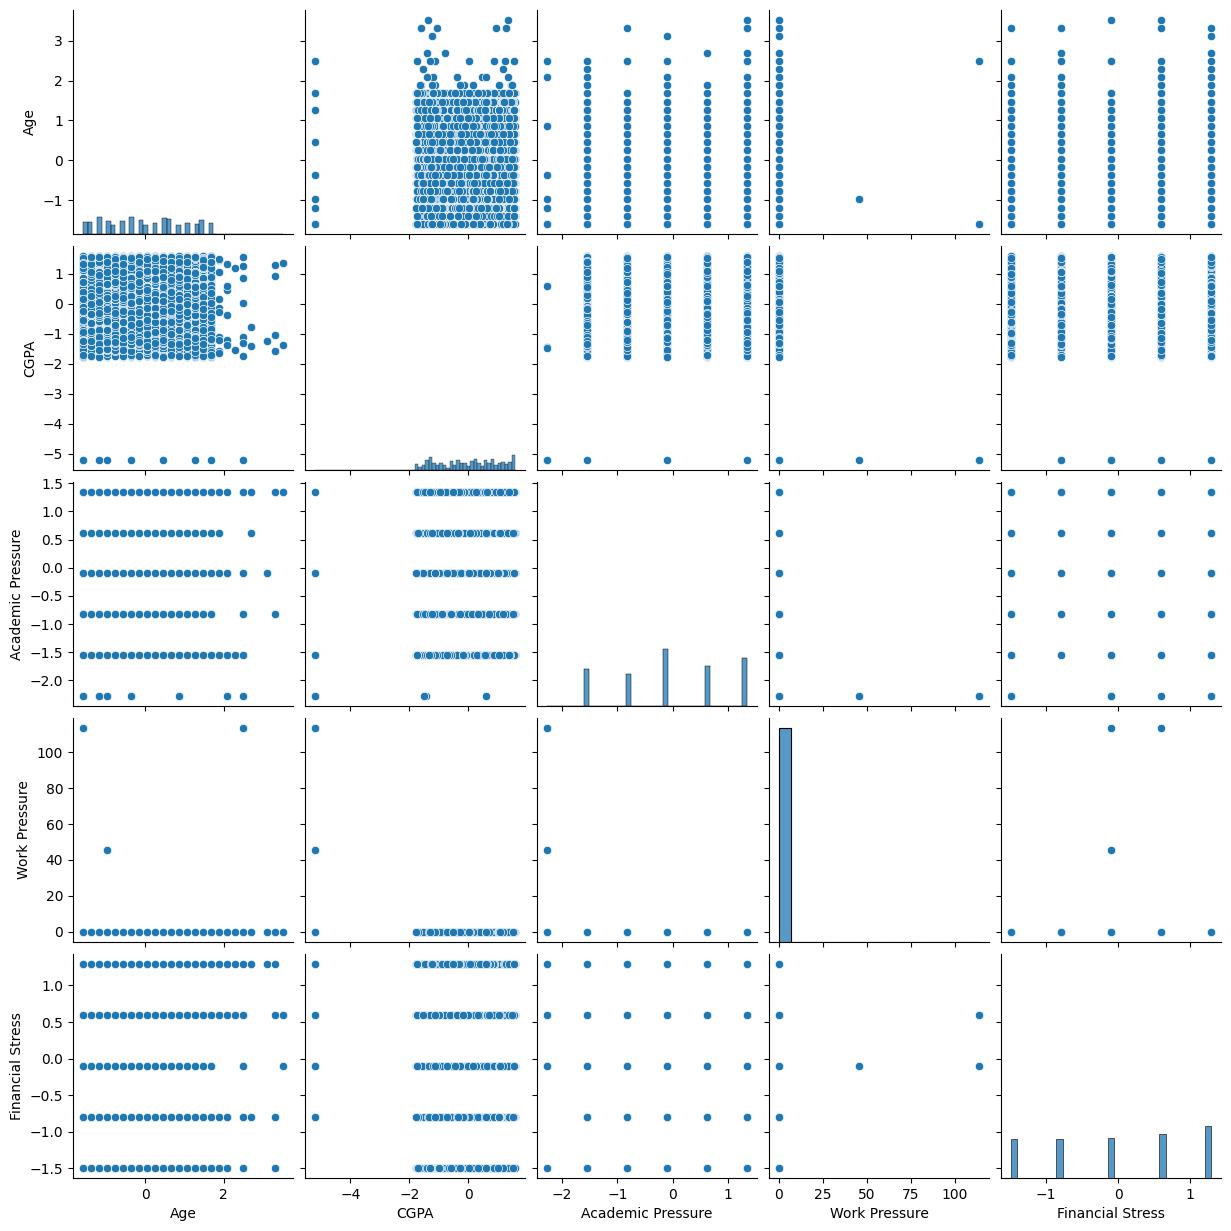

In [51]:
sns.pairplot(df[["Age","CGPA","Academic Pressure","Work Pressure","Financial Stress"]])
plt.show()

In [52]:
# Trigger download to your machine (Colab)
from google.colab import files

# Define out_path here as it might not be defined if previous cells weren't run
out_path = "student_depression_features.csv"

files.download(out_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>